In [35]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [36]:
import muon
import ott
import functools
import logging
import typing as t

import anndata as ad
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import scanpy as sc
import scipy.sparse as sp
import scipy.stats as ss
from ott.geometry import costs, geometry, pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.solvers.linear import sinkhorn
from ott.tools import sinkhorn_divergence
from sklearn import metrics, model_selection
from ott.geometry import costs as sparse_costs

In [37]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation_all.h5mu")

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [38]:
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [39]:
adata = mudata["rna"]
adata = adata[adata.obs["cell_type"].isin(endocrine_celltypes)]


In [40]:
def adapt_time(x):
    if x["stage"]=="E14.5":
        return 14.5
    if x["stage"]=="E15.5":
        return 15.5
    if x["stage"]=="E16.5":
        return 16.5
    raise ValueError

adata.obs['time'] = adata.obs.apply(adapt_time, axis=1).astype("category")

/tmp/ipykernel_2050456/440930313.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['time'] = adata.obs.apply(adapt_time, axis=1).astype("category")


In [41]:
adata = adata[adata.obs["time"].isin((15.5, 16.5))]

In [42]:
adata.X = adata.layers["raw_counts"]

In [43]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [44]:
sc.pp.highly_variable_genes(adata, inplace=True, subset=True, n_top_genes=2000)

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [45]:
adata

AnnData object with n_obs × n_vars = 6810 × 2000
    obs: 'sample', 'name', 'stage', 'stage_num', 'int_id', 'seq_id_gex_id', 'seq_id_atac', 'reporter', 'experiment_batch', 'sequencing_batch', 'n_counts', 'log_counts', 'n_counts_rank', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'final_doublets', 'final_doublets_cat', 'doublet_calls', 'batch', 'size_factors', 'leiden', 'leiden_05_rna', 'leiden_05_atac', 'leiden_1_rna', 'leiden_1_atac', 'leiden_combined', 'leiden_gex_graph', 'leiden_ATAC_graph', 'leiden_wnn_graph', 'cell_type', 'cell_type_refined', 'S_score', 'G2M_score', 'phase', 'proliferation', 'time'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'ambient_genes_E14_5-0', 'is_ambient_E14_5-0', 'n_counts-0', 'n_counts-1', 'ambient_genes_E15_5-1', 'is_ambient_E15_5-1', 'n_counts-2', 'ambient_genes_NVF_E15-5_Rep2-2', 'is_ambient_NVF_E15-5_Rep2-2', 'n_counts-3', 'ambient_genes_NVF_E16-5_Rep1-3', 'is_ambient_NVF_E16-5_Rep1-3', 'is_ambient', 'n_counts', 'n_cells'

In [46]:
gex_early = adata[adata.obs["time"]==15.5].X.A
gex_late = adata[adata.obs["time"]==16.5].X.A

In [47]:
x=gex_early
y=gex_late

In [48]:
solver = jax.jit(sinkhorn.Sinkhorn())


def entropic_map(x, y, cost_fn: costs.TICost) -> jnp.ndarray:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn, batch_size=1)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport

In [49]:
map_l1 = entropic_map(x, y, costs.ElasticL1(scaling_reg=50.0))

In [50]:
from tqdm import tqdm
batch_size=64
push_forward = []
for i in tqdm(range(0, len(x), batch_size)):
    push_forward.append(map_l1(x[i:i+batch_size]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [2:04:32<00:00, 93.41s/it]


In [51]:
ls_flattened=[]
for el in push_forward:
    ls_flattened.extend(el)

In [52]:
res=np.asarray(ls_flattened)

In [53]:
np.save("elastic_l1_50_2.npy", res)

In [55]:
gene_mask = (np.abs(res-x) > 1e-6)

In [56]:
adata_15 = adata[adata.obs["time"].isin((15.5, ))]

In [57]:
adata_15.layers["sparse_mask"] = gene_mask

/tmp/ipykernel_2050456/1174042063.py:1: ImplicitModificationWarning: Setting element `.layers['sparse_mask']` of view, initializing view as actual.
  adata_15.layers["sparse_mask"] = gene_mask


In [58]:
adata_15.var["sparse_counts"] = adata_15.layers["sparse_mask"].sum(axis=0)
adata_15.obs["sparse_counts"] = adata_15.layers["sparse_mask"].sum(axis=1)

In [59]:
adata_15.var["sparse_counts"].sort_values()[-5:]/len(adata_15)

Lmod3            0.185583
4930404H11Rik    0.185778
Iapp             0.408088
Ins1             0.645243
Ins2             0.672006
Name: sparse_counts, dtype: float64

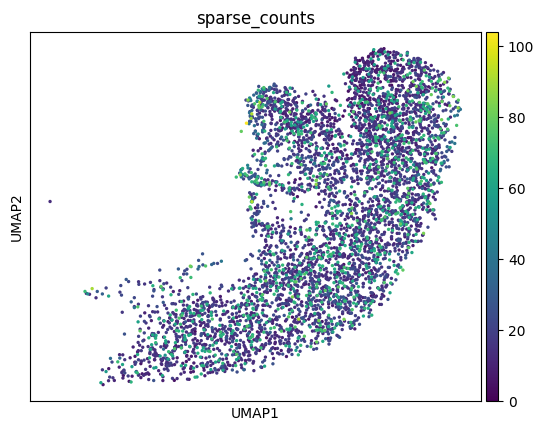

In [60]:
sc.pl.umap(adata_15, color='sparse_counts')

In [61]:
res_dict = {}
res_dict_2 = {}
for cell_type in endocrine_celltypes:
    adata_tmp = adata_15[adata_15.obs["cell_type"]==cell_type]
    adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
    adata_tmp.obs["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=1)
    res_dict[cell_type] = adata_tmp.var["sparse_counts"].sort_values()[-5:]/len(adata_tmp)
    res_dict_2[cell_type] = (adata_tmp.var["sparse_counts"]/len(adata_tmp)).var()

/tmp/ipykernel_2050456/2226181577.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)


In [62]:
res_dict

{'Ngn3 low': Vim      0.197635
 Lmod3    0.207770
 Iapp     0.650338
 Ins1     0.853041
 Ins2     0.876689
 Name: sparse_counts, dtype: float64,
 'Ngn3 high': Slc22a29    0.192614
 Mfap4       0.196235
 Iapp        0.561188
 Ins1        0.778421
 Ins2        0.836350
 Name: sparse_counts, dtype: float64,
 'Fev+': Gm28175    0.193277
 Chgb       0.268908
 Iapp       0.589916
 Ins1       0.774790
 Ins2       0.800000
 Name: sparse_counts, dtype: float64,
 'Fev+ Alpha': Arx     0.244604
 Chgb    0.395683
 Iapp    0.510791
 Ins1    0.805755
 Ins2    0.812950
 Name: sparse_counts, dtype: float64,
 'Fev+ Beta': Gm14341    0.172762
 Gm14252    0.172762
 Iapp       0.208071
 Ins2       0.519546
 Ins1       0.534678
 Name: sparse_counts, dtype: float64,
 'Fev+ Delta': Gm13497    0.174242
 Mdk        0.250000
 Iapp       0.575758
 Ins1       0.787879
 Ins2       0.840909
 Name: sparse_counts, dtype: float64,
 'Eps. progenitors': Gm15632    0.232323
 Gm48488    0.242424
 Iapp       0.565657
 Ins1

In [63]:
import pandas as pd
df = pd.DataFrame.from_dict(res_dict_2, orient="index")#.sort_values("score")

In [64]:

df.sort_values(0)

,0
Beta,0.000764
Fev+ Beta,0.000993
Alpha,0.001063
Delta,0.001463
Fev+ Alpha,0.001608
Fev+ Delta,0.001646
Fev+,0.001721
Epsilon,0.001727
Ngn3 high,0.001770
Ngn3 low,0.002021


In [65]:
sc.pp.pca(adata_15)
sc.pp.neighbors(adata_15, n_neighbors=30)

In [66]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

js = []
for i in tqdm(range(len(adata_15))):
    neighbors = (adata_15.obsp["distances"][i]>0).T
    adata_cell = adata_15[i]
    adata_tmp = adata_15[list(neighbors.A[:,0])]   
    adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
    genes_neighborhood = adata_tmp.var["sparse_counts"][adata_tmp.var["sparse_counts"]>0].index
    genes_cell = adata_cell.var["sparse_counts"][adata_cell.var["sparse_counts"]>0].index
    js.append(jaccard_similarity(set(genes_neighborhood), set(genes_cell)))
    
    
    
    

  0%|                                                                                                                                                            | 0/5119 [00:00<?, ?it/s]/tmp/ipykernel_2050456/2905907617.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5119/5119 [02:23<00:00, 35.66it/s]


In [67]:
adata_15.obs["js_inv"] = 1-np.asarray(js)

In [68]:
adata_15.obs[["cell_type_refined", "js_inv"]].groupby("cell_type_refined").mean().sort_values("js_inv")

/tmp/ipykernel_2050456/2605882233.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_15.obs[["cell_type_refined", "js_inv"]].groupby("cell_type_refined").mean().sort_values("js_inv")


,js_inv
cell_type_refined,
Delta,0.784530
Fev+ Alpha,0.817260
Alpha,0.823867
Epsilon,0.826368
Fev+ Beta,0.833144
Fev+,0.834854
Fev+ Delta,0.842597
Beta,0.846107
Ngn3 high,0.853345


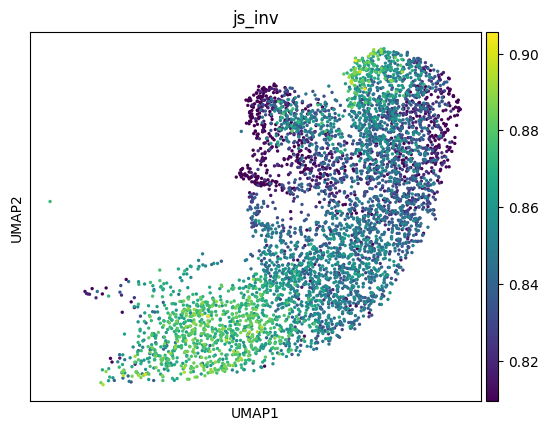

In [69]:
sc.pl.umap(adata_15, color="js_inv", vmin="p10")